# Point spread function covariance

In order to use the NLL with a MVG distribution, the assumption was that the covariance $\Sigma$ of the model was Identity in its representation, essentially for $\Sigma\in\mathbb{R}^{22500\times22500}$, the matrix was represented as $\text{diag(1,1,...,1)}$

This assumption works for data (pixels) that are i.i.d, however in Radio astronomy, this is not the case. Data are read in as fourier components, and during processing are convolved, this leads to *point spread*, where point sources have been smeared across multiple pixels. We know from [the webiste](https://sundog.stsci.edu/first/catalogs/readme.html) that VLA-FIRST, where RGZ108k (dataset used is from) has a point spread of 1.8 arcseeconds. This means that each pixel represents a distance $\mathbf{x}$ of $(\text{RA},\delta)=(1.8,1.8)$. We also know the point-spread in the north,south is 5.4,6.4.

## Assumptions:

- We will do away with the 6.4, and assume the point-spread distribution is governed only by the 5.4, which gives the point spread $p(x)\sim \mathcal{N}(x;0,\sigma^2)$ wheere $\sigma=\frac{5.4}{2\sqrt{2\ln{2}}}$
- While calculations of distrance in $(\text{RA},\delta)$ can be done, for ease the calculation will be done for demonstration in Euclidean space $(x,y)$, allowing to take the $L_2$ norm.

The algorithm can be thought of as, for two pixels in an image $(i,j)$,$(k,l)$:
$$
d_{(i,j),(k,l)} = 1.8\sqrt{(i-k)^2+(j-l)^2}
$$

This results in a correlation:

$$
C_{(i,j),(k,l)} = \mathcal{N}(d;0,\sigma^2)
$$

The implementation is followed:

In [1]:
import numpy as np
from scipy.stats import norm

image_size = 150
sigma = 5.4 / (2 * np.sqrt(2 * np.log(2)))
normal = norm(loc=0,scale=sigma)

x, y = np.meshgrid(np.arange(image_size), np.arange(image_size), indexing="ij")
pixel_coords = np.stack((x.ravel(), y.ravel()), axis=1)

pixels = image_size**2
correlation_matrix = np.zeros((pixels,pixels))

```
for q in range(pixels):
    i,j = pixel_coords[q]
    for r in range(pixels):
        if q == r: # Diagonal entries
            correlation_matrix[q,r]=1
        else:
            k,l = pixel_coords[r] # For pixel 2
            d =  d = np.sqrt((i - k) ** 2 + (j - l) ** 2)
            C = normal.pdf(d)
            correlation_matrix[q,r] = C
```

Killed at 2.5 mins

```
for q in range(pixels):
    i,j = pixel_coords[q]
    for r in range(pixels):
        if q == r: # Diagonal entries
            correlation_matrix[q,r]=1
        else:
            k,l = pixel_coords[r] # For pixel 2
            d = np.sqrt((i - k) ** 2 + (j - l) ** 2)
            C = 1/(np.sqrt(np.pi * 2 * sigma))* np.exp(-np.power(d,2)/(2*sigma**2))
            correlation_matrix[q,r] = C
```

Killed after 10 minutes

Try calculating C in a vectorised way

In [ ]:
i, j = pixel_coords[:, 0], pixel_coords[:, 1] 

di = i[:, None] - i[None, :] # Difference in x for all coordinates
dj = j[:, None] - j[None, :] # Difference in y for all coordinats
d = 1.8*np.sqrt(di**2 + dj**2) # d[x,x'] difference in euclidean distance between the two pixels in the (RA,\delta) ~ Euclidean R^{22500 \otimes 22500}

C= (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-d**2 / (2 * sigma**2)) # Just the N(0,sigma^2)

# Set the diagonal elements to 1
np.fill_diagonal(C, 1)

# Assign the result
correlation_matrix = C

~1m 4.6 to create

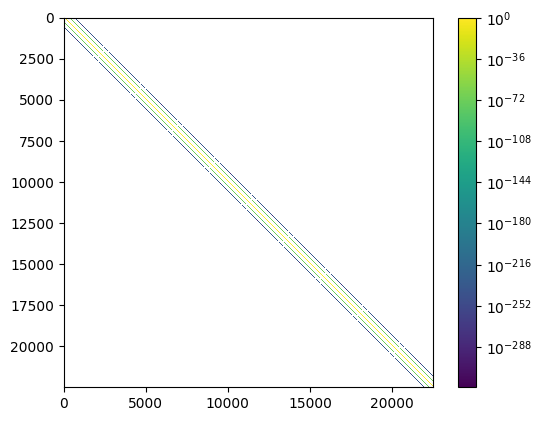

In [3]:
import matplotlib.pyplot as plt
plt.imshow(correlation_matrix, cmap='viridis', interpolation='nearest',norm="log")
plt.colorbar()  # Add color scale
plt.show()

Correlation Drops off massively (expected)

### Example use case with PyTorch

In [ ]:
import torch
def find_correlation_matrix(image_size,sigma):
    """
    - Inputs:
        - image_size: data dimensionality
        - sigma: standard deviation of the target distribution.
    - Outputs:
        - Correlation matrix: the corrlation matrix as specified in the algorithm in the markdown cells above.
    """
    x, y = np.meshgrid(np.arange(image_size), np.arange(image_size), indexing="ij")
    pixel_coords = np.stack((x.ravel(), y.ravel()), axis=1)
    i, j = pixel_coords[:, 0], pixel_coords[:, 1] 

    di = i[:, None] - i[None, :] # Difference in x for all coordinates
    dj = j[:, None] - j[None, :] # Difference in y for all coordinats
    d = 1.8*np.sqrt(di**2 + dj**2) # d[x,x'] difference in euclidean distance between the two pixels in the (RA,\delta) ~ Euclidean R^{22500 \otimes 22500}

    C= (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-d**2 / (2 * sigma**2)) # Just the N(0,sigma^2)

    # Set the diagonal elements to 1
    np.fill_diagonal(C, 1)

    # Assign the result
    correlation_matrix = C
    return correlation_matrix
correlation_matrix = find_correlation_matrix(image_size, sigma)
correlation_matrix = torch.tensor(correlation_matrix, dtype=torch.float32)


![Algorithm Breakdown](Screenshot%202025-02-13%20145349.png)

## Attempting to reduce computation.

The full covariance matrix contains $(2250\times 22500)$ eentries, and therefore calculations involving it will be incraeseed by this factor.

Need a way to reduce the dimensionality of these operations.

I will attmpt to implement:
- Singular Value Decomposition.
- Cholesky Decomposition.

The equation of interest in this case is the Multivariat Gaussian negative loss likelihood, where for an n-dimensional Multivariate Gaussian:
$$
\mathcal{L} = \frac{1}{2}\left[
    \log |\Sigma| + (x-\mu)^\intercal \Sigma^{-1} (x-\mu)+n\log 2\pi
\right]
$$

The matrix is symmetric and positive definite (SPD) due to the formulation of $d$ and $C$. This allows us to use Singular Value decomposition, which uses the fact that any SPD matrix has a full eigenvalue problem:

$$\Sigma = Q\Lambda Q^\intercal$$

Where $Q$ is the matrix populated with columns of eigenvectors, and $\Lambda$ is populated by the eigenvalues as $\text{diag}(\lambda_1,...,\lambda_n)\in\mathbb{R}$. It should also be noted that $Q$ is orthogonal s.t. $QQ^\intercal=I$.

Due to this it is simple to see:

$$
\Sigma = Q\Lambda Q^\intercal\\
|\Sigma| = |\Lambda| = \prod_i\lambda_i\\
\log|\Sigma|=\sum_i \log\lambda_i
$$

The NLL has two terms of interest that we want to reduce, the log determinant (above), and also $(x-\mu)^\intercal \Sigma^{-1} (x-\mu)$. So:

$$
\Sigma^{-1}=Q\Lambda^-1Q^\intercal\\
(x-\mu)^\intercal Q\Lambda^-1Q^\intercal (x-\mu)\\
z^\intercal=(x-\mu)^\intercal Q\\
z=Q^\intercal (x-\mu)
$$

So the problem is now:
$$
(x-\mu)^\intercal \Sigma^{-1} (x-\mu) = z^\intercal\Lambda^{-1}z = \sum_i\frac{z_i^2}{\lambda_i}
$$


$$
\mathcal{L}_{SVD} = \frac{1}{2}\left[
                        \sum_i\log\lambda_i + \sum_i\frac{z_i^2}{\lambda_i} + n\log(2\pi)
\right]
$$

In [3]:
def negative_log_likelihood_full(x, mu, cov):
    diff = x - mu
    n = len(x)
    
    # Compute log determinant using slogdet for numerical stability.
    sign, logdet = np.linalg.slogdet(cov)
    if sign <= 0:
        raise ValueError("Covariance matrix is not positive definite!")
    
    # Compute the quadratic term.
    inv_cov = np.linalg.inv(cov)
    quad_term = diff.T @ inv_cov @ diff
    
    nll = 0.5 * (logdet + quad_term + n * np.log(2 * np.pi))
    return nll

def negative_log_likelihood_svd(x, mu, cov):
    U, s, Vh = np.linalg.svd(cov)
    diff = x - mu
    n = len(x)
    
    # Log determinant is the sum of the logarithms of the singular values.
    logdet = np.sum(np.log(s))
    
    # Transform diff into the SVD basis.
    z = Q.T @ diff
    quad_term = np.sum((z**2) / s)
    
    nll = 0.5 * (logdet + quad_term + n * np.log(2 * np.pi))
    return nll

In [5]:
image_size = 50 
cov = find_correlation_matrix(image_size, sigma)
n = image_size**2  # dimension of the Gaussian

x = np.random.randn(n)
mu = np.random.randn(n)

# Compute the NLL using the full covariance matrix method.
nll_full = negative_log_likelihood_full(x, mu, cov)

# Q = eigenvector matrix
Q, s, Vh = np.linalg.svd(cov)


nll_svd = negative_log_likelihood_svd(x, mu, cov)


print("Negative log likelihood (full covariance):", nll_full)
print("Negative log likelihood (SVD formulation):", nll_svd)
print("Difference:", np.abs(nll_full - nll_svd))

Negative log likelihood (full covariance): 4914.354678231707
Negative log likelihood (SVD formulation): 4914.354678231706
Difference: 9.094947017729282e-13


Cholesky Decomposition works for SPD matrices, and states that it can be broken down:

$$
\Sigma = LL^\intercal
$$

for $L$ being positive,diagonal, and *triangular*, a matrix type which allows for quicker solving of problems.

The log det term works as:

$$
|\Sigma|=|LL^\intercal|= |L|^2 = \prod_i L_{ii}^2\\
\log|\Sigma| = 2\sum_i \log L_{ii}
$$

The inverted term:
$$
(x-\mu)^\intercal \Sigma^{-1} (x-\mu) = (x-\mu)^\intercal (L^\intercal)^{-1}L^{-1} (x-\mu) = y^\intercal y= ||y||^2
$$

However, to avoid inverting the matrix, it is equivalent to exploit the triangular nature of the cholesky component, and instead solve for y:
$$
L^{-1}(x-\mu) = y \rightarrow Ly = x-\mu
$$
which is simple to solve due to L being triangular, using the package `scipy.linalg.solve_triangular`

$$
\mathcal{L}_{Cholesky} = \frac{1}{2}\left[
    2\sum_i\log L_{ii} + ||L^{-1}(x-\mu)||^2 +n\log(2\pi)
\right]
$$

In [8]:
from scipy.linalg import cholesky, solve_triangular

def negative_log_likelihood_cholesky(x, mu, cov):
    # 1. Compute the Cholesky decomposition: cov = L * L.T
    L = cholesky(cov, lower=True)
    
    # 2. Solve L * y = (x - mu) for y using forward substitution.
    #    This avoids the explicit computation of the inverse.
    y = solve_triangular(L, x - mu, lower=True)
    
    # 3. The quadratic form becomes: (x-mu)^T cov^{-1} (x-mu) = ||y||^2
    quad_term = np.dot(y, y)
    
    # 4. Compute the log-determinant using the Cholesky factor:
    #    log(det(cov)) = 2 * sum(log(diag(L)))
    log_det = 2 * np.sum(np.log(np.diag(L)))
    
    # 5. Combine to form the full negative log likelihood:
    n = len(x)
    nll = 0.5 * (log_det + quad_term + n * np.log(2 * np.pi))
    return nll


# Compute the negative log likelihood using the Cholesky approach
nll_chol = negative_log_likelihood_cholesky(x, mu, cov)
print("Negative Log Likelihood (Cholesky):", nll_chol)

Negative Log Likelihood (Cholesky): 4914.354678231706


In [9]:
print("Negative log likelihood (full covariance):", nll_full)
print("Negative log likelihood (SVD formulation):", nll_svd)
print("Negative Log Likelihood (Cholesky):", nll_chol)
print("Difference:", np.abs(nll_full - nll_chol))

Negative log likelihood (full covariance): 4914.354678231707
Negative log likelihood (SVD formulation): 4914.354678231706
Negative Log Likelihood (Cholesky): 4914.354678231706
Difference: 9.094947017729282e-13


In [ ]:
import time
num_iter = 20

# Full covariance method timing
start_full = time.perf_counter()
for _ in range(num_iter):
    nll_full = negative_log_likelihood_full(x, mu, cov)
time_full = (time.perf_counter() - start_full) / num_iter

# SVD method timing
start_svd = time.perf_counter()
for _ in range(num_iter):
    nll_svd = negative_log_likelihood_svd(x, mu, cov)
time_svd = (time.perf_counter() - start_svd) / num_iter

# Cholesky method timing
start_chol = time.perf_counter()
for _ in range(num_iter):
    nll_chol = negative_log_likelihood_cholesky(x, mu, cov)
time_chol = (time.perf_counter() - start_chol) / num_iter


print("Average time per call (Full):     {:.2e} seconds".format(time_full))
print("Average time per call (SVD):      {:.2e} seconds".format(time_svd))
print("Average time per call (Cholesky): {:.2e} seconds".format(time_chol))

times = {"Full": time_full, "SVD": time_svd, "Cholesky": time_chol}
fastest = min(times, key=times.get)
print("Fastest method:", fastest)

Average time per call (Full):     1.14e+00 seconds
Average time per call (SVD):      7.00e+00 seconds
Average time per call (Cholesky): 2.00e-01 seconds
Fastest method: Cholesky


In [11]:
# Check if covariance matrix is symmetric
is_symmetric = np.allclose(cov, cov.T, atol=1e-10)
print("Is covariance matrix symmetric?", is_symmetric)

Is covariance matrix symmetric? True


In [ ]:
if is_psd:
    # Compute inverse using Cholesky
    L = cholesky(cov, lower=True)
    L_inv = np.linalg.inv(L)
    chol_inv = L_inv.T @ L_inv

    # Compute direct inverse
    direct_inv = np.linalg.inv(cov)

    # Check if the two inverses are close
    are_inverses_close = np.allclose(chol_inv, direct_inv, atol=1e-30)
    print("Is Cholesky inverse the same as direct inverse?", are_inverses_close)

Is Cholesky inverse direct inverse? True


In [23]:
import sys

# Compute the actual memory usage of the covariance matrix and Cholesky factor
cov_size = sys.getsizeof(cov)
try:
    L = cholesky(cov, lower=True)
    L_size = sys.getsizeof(L)
except np.linalg.LinAlgError:
    L_size = None  # Cholesky decomposition failed

# Convert bytes to megabytes
cov_size_mb = cov_size / (1024**2)
L_size_mb = L_size / (1024**2) if L_size else None

# Print results
print(f"Actual Memory Usage:")
print(f" - Full Covariance Matrix: {cov_size_mb:.2f} MB")
if L_size is not None:
    print(f" - Cholesky Factor (Lower Triangular): {L_size_mb:.2f} MB")
    print(f" - Cholesky requires {cov_size_mb / L_size_mb:.2f}x less memory than storing full covariance.")
else:
    print(" - Cholesky decomposition failed, unable to compute size.")


Actual Memory Usage:
 - Full Covariance Matrix: 47.68 MB
 - Cholesky Factor (Lower Triangular): 47.68 MB
 - Cholesky requires 1.00x less memory than storing full covariance.


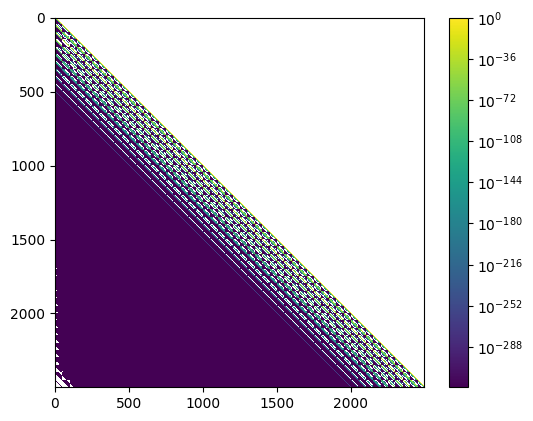

In [36]:
import matplotlib.colors as mcolors

cmap = plt.cm.viridis.copy()
cmap.set_bad('white') 
L_masked = np.ma.masked_where(L == 0, L)

# Apply logarithmic normalization, ignoring zero values
norm = mcolors.LogNorm(vmin=L[L > 0].min(), vmax=L.max())

plt.imshow(L_masked, cmap=cmap, norm=norm, interpolation='nearest')
plt.colorbar()  # Add color scale
plt.show()
